In [3]:
import torch
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance_matrix

In [4]:

# Load a pre-trained MiDaS model
model_type = "DPT_Hybrid"  # or "MiDaS_small" for faster inference with lower accuracy
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Prepare the input image
img = Image.open("classroom.jpg")
transform = Compose([
    Resize(385),
    ToTensor()
])
input_tensor = transform(img).unsqueeze(0).to(device)

# Predict depth
with torch.no_grad():
    depth = midas(input_tensor)

depth = depth.squeeze().cpu().numpy()

# Visualize the depth map
plt.imshow(depth, cmap='plasma')
plt.colorbar()
plt.show()


Using cache found in /Users/alicemguler/.cache/torch/hub/intel-isl_MiDaS_master
/Users/alicemguler/NoSyncDocuments/IoTCountingAndCoModel/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/alicemguler/NoSyncDocuments/IoTCountingAndCoModel/.venv/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


RuntimeError: The size of tensor a (826) must match the size of tensor b (769) at non-singleton dimension 1

Using cache found in /Users/alicemguler/.cache/torch/hub/intel-isl_MiDaS_master


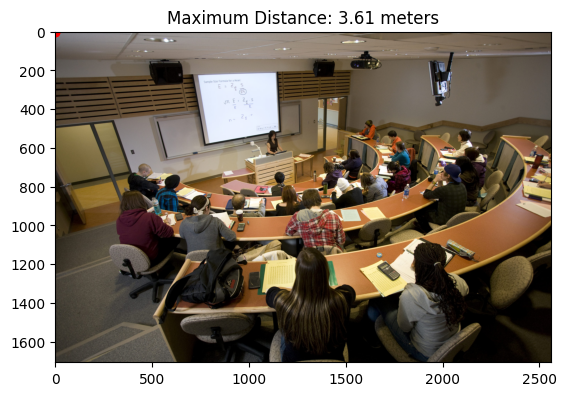

In [8]:
# Load the MiDaS model
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

# Image transform
transform = Compose([
    Resize((1024, 1024)),  # Ensure the image is resized to fixed dimensions
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor, img

def depth_to_pointcloud(depth, f, cx, cy, pixel_size, depth_scale=1, downsample_factor=1):
    h, w = depth.shape
    if downsample_factor > 1:
        depth = depth[::downsample_factor, ::downsample_factor]  # Downsample depth map
        i, j = np.meshgrid(np.arange(w//downsample_factor), np.arange(h//downsample_factor), indexing='xy')
    else:
        i, j = np.meshgrid(np.arange(w), np.arange(h), indexing='xy')
    x = (i - cx / downsample_factor) * depth * pixel_size / f
    y = (j - cy / downsample_factor) * depth * pixel_size / f
    z = depth * depth_scale
    points = np.stack((x, y, z), axis=-1)
    return points.reshape(-1, 3), (i, j)


def find_max_distance(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    max_distance = 0
    endpoints = None
    # Check distances only between points on the convex hull
    for i in range(len(hull_points)):
        for j in range(i + 1, len(hull_points)):
            dist = np.linalg.norm(hull_points[i] - hull_points[j])
            if dist > max_distance:
                max_distance = dist
                endpoints = (hull_points[i], hull_points[j])
    return max_distance, endpoints


# Main execution
if __name__ == "__main__":
    image_path = "classroom.jpg"
    focal_length_pixels = 1  # Example, need actual value
    image_center_x, image_center_y = 1024 / 2 , 1024  / 2  # Adjust these based on image dimensions
    pixel_size = 1.12e-6  # Example pixel size in meters
    depth_scale = 0.001  # Convert depth to meters if necessary

    # Load and process image
    img_tensor, original_img = load_image(image_path)

    # Predict depth
    with torch.no_grad():
        depth_tensor = midas(img_tensor)
        depth = depth_tensor.squeeze().cpu().numpy()

    # Convert depth to 3D points
    points, (i, j) = depth_to_pointcloud(depth, focal_length_pixels, image_center_x, image_center_y, pixel_size, depth_scale)

    # Calculate the maximum distance and get the points
    max_distance, endpoints = find_max_distance(points)

    # Draw the line on the image
    fig, ax = plt.subplots()
    ax.imshow(original_img)
    ax.plot([endpoints[0][1], endpoints[1][1]], [endpoints[0][0], endpoints[1][0]], 'ro-')  # Plot as red line with dots
    ax.set_title(f"Maximum Distance: {max_distance:.2f} meters")
    plt.show()